In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
from ensemble_boxes import *

In [2]:
carpart_config = '../checkpoints/12_10/carpart/swa_carpart.py'
carpart_checkpoint = '../checkpoints/12_10/carpart/swa_carpart.pth'
carpart_model = init_detector(carpart_config, carpart_checkpoint, device='cuda:0')

/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


In [3]:
scratch_config = '../checkpoints/12_10/scratch/swa_scratch_pseudo.py'
scratch_checkpoint = '../checkpoints/12_10/scratch/swa_scratch_12_10.pth'
scratch_model = init_detector(scratch_config, scratch_checkpoint, device='cuda:0')

Use load_from_local loader


In [4]:
crack_config = '../checkpoints/combine_crack_phase_1/combine_crack.py'
crack_checkpoint = '../checkpoints/combine_crack_phase_1/epoch_28.pth'
crack_model = init_detector(crack_config, crack_checkpoint, device='cuda:0')

Use load_from_local loader


In [5]:
glass_broken_config = '../checkpoints/windshield/windshield.py'
glass_broken_checkpoint = '../checkpoints/windshield/swa_model_11.pth'
glass_broken_model = init_detector(glass_broken_config, glass_broken_checkpoint, device='cuda:0')

Use load_from_local loader


In [ ]:
#data = Path('/mmdetection/data/cracked_windshield_flickr')
#files = [str(i) for i in data.iterdir() if i.is_file()]
#print(files)
path = Path('/mmdetection/data/windshield/glass_broken')
data = json.load(open(path/'annotations'/'test.json'))
total = json.load(open(path/'annotations'/'total.json'))
print(len(total['annotations']))

In [6]:
carpart_labels = carpart_model.CLASSES
np.random.seed(42)
mask_colors = [
    np.random.randint(0, 256, (1, 3), dtype=np.uint8)
    for _ in range((len(carpart_labels)))
]

def plot_windshield(image,segms,labels):
    for idx,s in enumerate(segms):
        color = mask_colors[labels[idx]]
        color = color.tolist()
        #score = round(scores[idx],2)
        #print(color)
        #print(s)
        
        contours, _ = cv2.findContours(np.array(s).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #c = []
        if len(contours) == 0:
            continue
            
        c = max(contours,key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] != 0:
            cy = int(M["m01"] / M["m00"])
        else:
            cy = c[0][0][1]
            
        cx = [idi for idi,i in enumerate(s[cy]) if i][0]        
        
        image = cv2.drawContours(image,contours,-1,list(color[0]),2)
        #image = cv2.putText(image,carpart_labels[labels[idx]],(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,1,list(color[0]),2,cv2.LINE_AA)
    
    return image

def plot_crack(image,segms,labels,scores):
    for idx,s in enumerate(segms):
        #color = 
        #color = mask_colors[labels[idx]]
        #color = color.tolist()
        score = round(scores[idx],2)
        #print(color)
        #print(s)
        
        contours, _ = cv2.findContours(np.array(s).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            continue
            
        c = max(contours,key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] != 0:
            cy = int(M["m01"] / M["m00"])
        else:
            cy = c[0][0][1]
            
        cx = [idi for idi,i in enumerate(s[cy]) if i][0]        
        
        image = cv2.drawContours(image,contours,-1,(255,0,255),2)
        image = cv2.putText(image,str(score)+'|crack |'+str(s.sum()),(cx+10,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    
    return image

In [7]:
def nms_float_fast(dets, thresh):
    """
    # It's different from original nms because we have float coordinates on range [0; 1]
    :param dets: numpy array of boxes with shape: (N, 5). Order: x1, y1, x2, y2, score. All variables in range [0; 1]
    :param thresh: IoU value for boxes
    :return: index of boxes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    
    scores = dets[:,4]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        #print(i)
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
       
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        #print(inds)
        #print(order)
        order = order[inds + 1]

    return keep

def check_windshield(segms,labels):
    ws = [(s,l) for idx,(s,l) in enumerate(zip(segms,labels)) if carpart_labels[l] == 'fwi_windshield']
    segms_out = [i[0] for i in ws]
    labels_out = [i[1] for i in ws]
    
    return segms_out,labels_out

#def carpart_inference(model,image,confident_score):
#    result = inference_detector(model,image.copy())
#    _,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model,image.copy(),result,score_thr=confident_score)
    
#    return pred_boxes,pred_segms,pred_labels,pred_scores

def damage_inference(image,confident_score):
    crack_result = inference_detector(crack_model,image.copy())
    scratch_result = inference_detector(scratch_model,image.copy())
    
    crack_result[0][0] = np.concatenate((crack_result[0][0],scratch_result[0][0]))
    crack_result[1][0].extend(scratch_result[1][0])
    #print('result :',crack_result[0][0])
    h,w = image.shape[:2]
    #print(h,w)
    boxes = crack_result[0][0]
    for idx,b in enumerate(boxes):
        boxes[idx][0] = boxes[idx][0] / w 
        boxes[idx][1] = boxes[idx][1] / h
        boxes[idx][2] = boxes[idx][2] / w
        boxes[idx][3] = boxes[idx][3] / h
    #print(boxes[:,4])
    #print(boxes)
    keep = nms_float_fast(boxes,0.4)
    #print(keep)
    crack_result[0][0] = boxes[keep]
    #print('segms :',crack_result[1][0])
    crack_result[1][0] = np.asarray(crack_result[1][0])[keep].tolist()
    
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(crack_model,image.copy(),crack_result,score_thr=confident_score)
    
    return pred_boxes,pred_segms,pred_labels,pred_scores

def single_model_inference(model,image,confident_score):
    result = inference_detector(model,image.copy())
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model,image.copy(),result,score_thr=confident_score)
    
    return pred_boxes,pred_segms,pred_labels,pred_scores

def damage_inference_v2(image,crack_confident,scratch_confident):    
    def filter_confident(det_result,confident):
        boxes = det_result[0][0]
        keep = np.where(boxes[:,4] >= confident)[0]
        det_result[0][0] = boxes[keep]
        det_result[1][0] = np.asarray(det_result[1][0])[keep].tolist()
        
        return det_result
    
    crack_result = inference_detector(crack_model,image.copy())
    crack_result = filter_confident(crack_result,crack_confident)
    
    scratch_result = inference_detector(scratch_model,image.copy())
    scratch_result = filter_confident(scratch_result,scratch_confident)
    
    crack_result[0][0] = np.concatenate((crack_result[0][0],scratch_result[0][0]))
    crack_result[1][0].extend(scratch_result[1][0])

    h,w = image.shape[:2]
    boxes = crack_result[0][0]
    
    for idx,b in enumerate(boxes):
        boxes[idx][0] = boxes[idx][0] / w 
        boxes[idx][1] = boxes[idx][1] / h
        boxes[idx][2] = boxes[idx][2] / w
        boxes[idx][3] = boxes[idx][3] / h

    keep = nms_float_fast(boxes,0.3)
    crack_result[0][0] = boxes[keep]
    crack_result[1][0] = np.asarray(crack_result[1][0])[keep].tolist()
    
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(crack_model,image.copy(),crack_result,score_thr=0.01)
    
    if pred_segms is None:
        pred_segms = []
    return pred_boxes,pred_segms,pred_labels,pred_scores

def glass_broken_inference(image,confident):
    result = inference_detector(glass_broken_model,image.copy())
    _,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(glass_broken_model,image.copy(),result,score_thr=confident)
    
    if pred_segms is None :
        pred_segms = []
    
    return pred_boxes,pred_segms,pred_labels,pred_scores
    
def windshield_inference(image):
    ####### car part inference
    carpart_result = single_model_inference(carpart_model,image,0.7)
    #print(*carpart_result[1:3])
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    ###### damge inference 
    #boxes,segms,labels,scores = damage_inference_v2(image.copy(),crack_confident=0.64,scratch_confident=0.62)
    boxes,segms,labels,scores = glass_broken_inference(image,confident=0.6)
    ###### post processing
    # check inside windshield
    
    if len(windshield_semgs) > 0 and len(segms) > 0:
        check = [False for _ in range(len(segms))]
        for idx,s in enumerate(segms): 
            if s.sum() == 0:
                continue
            intersect_check = [np.logical_and(s,ws).sum()/s.sum() > 0.7 for ws in windshield_semgs]
            #print(s.sum(),[np.logical_and(s,ws).sum()/s.sum() for ws in windshield_semgs])
            intersect_check = sum(intersect_check) > 0
            check[idx] = intersect_check

        boxes = np.array(boxes)[check]
        #print(len(segms),check)
        segms = segms[check]
        labels = labels[check]
        scores = scores[check]
        
    out = plot_windshield(image,windshield_semgs,windshield_labels)
    out = plot_crack(out,segms,labels,scores)
    
    return out

In [ ]:
'''
image = cv2.imread(files[145])

#damage_inference_v2(image,0.7,0.5)
plt.figure(figsize=(15,10))
show = cv2.cvtColor(np.hstack((image,windshield_inference(image.copy()))),cv2.COLOR_RGB2BGR)
plt.figure(figsize=(15,10))
plt.imshow(show)
'''
i = data['images'][0]
image = cv2.imread(str(path/'images'/i['file_name']))
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==i['id']]
new_image = cv2.drawContours(image.copy(),annos,-1,(255,255,0))
plt.figure(figsize=(15,10))
plt.imshow(new_image)

In [ ]:
out_folder = 'windshield_test'
Path(out_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(data['images']):
    #print(idx)
    img = cv2.imread(str(path/'images'/f['file_name']))
    annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==f['id']]
    new_img = cv2.drawContours(img.copy(),annos,-1,(255,0,255))
    img = np.hstack((new_img,windshield_inference(img.copy())))
    cv2.imwrite(out_folder+'/'+f['file_name'],img)

In [ ]:
path = Path('/mmdetection/data/tmp/windshield/instagram')
files = [str(i) for i in path.iterdir() if i.is_file()]
print(files)


out_folder = 'windshield_instagram'
Path(out_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(files):
    #print(idx)
    img = cv2.imread(f)
    #annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==f['id']]
    #new_img = cv2.drawContours(img.copy(),annos,-1,(255,0,255))
    img = np.hstack((img,windshield_inference(img.copy())))
    cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],img)

In [ ]:
s= '/mmdetection/data/tmp/windshield/instagram/119461813_3367613256685024_1741302932519352110_n.jpg'
s[s.rfind('/')+1:]

In [ ]:
# image file name need to be annotate
output = []
out_folder = 'windshield_anno'
Path(out_folder).mkdir(parents=True,exist_ok=True)

no_folder = 'windshield_no'
Path(no_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(files):
    #print(idx)
    img = cv2.imread(f)
    file_name = f[f.rfind('/')+1:]
    
    carpart_result = single_model_inference(carpart_model,img,0.9)
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    boxes,segms,labels,scores = glass_broken_inference(img,confident=0.6)
    
    # model unable to detect any damages -> need to be annotate
    if len(segms) == 0:
        output.append(f)
        
        cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # damage too large -> no
    areas_check = [s.sum() > 50116.5 for s in segms]
    if sum(areas_check) > 0:
        cv2.imwrite(no_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # image from closed distance and it not bigger than 0.4 area of images
    if len(windshield_semgs) == 0:
        area = img.shape[0]*img.shape[1]
        ratios = [s.sum()/area > 0.4  for s in segms]
        check = sum(ratios) == 0
        if check :
            output.append(f)
            cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
            continue
    
    # if there is any damage in windshield and smaller than 0.1*area winshield -> need to be annotate
    main_ws = max(windshield_semgs,key=lambda p:p.sum())
    
    intersect_check = [np.logical_and(s,main_ws).sum() / s.sum() > 0.6 for s in segms if s.sum() > 0 and main_ws.sum() > 0]
    size_check = [np.logical_and(s,main_ws).sum() / main_ws.sum() > 0.6 for s in segms if s.sum() > 0 and main_ws.sum() > 0]
    
    # check nothing in main windshield -> potential FP windshield -> need annotation review
    if sum(intersect_check) == 0:
        cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # check if damage too big -> no
    if np.logical_and(intersect_check,size_check).sum() > 0:
        cv2.imwrite(no_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))

In [ ]:
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in total['annotations']]
areas = np.array([cv2.contourArea(a) for a in annos])
bound = 1
print(np.quantile(areas,bound))

a,b,c = plt.hist(areas[areas < np.quantile(areas,bound)],bins=100)

In [ ]:
f = '/mmdetection/data/tmp/windshield/instagram/117646015_3084515648441475_7781753156080295698_n.jpg'
image = cv2.imread(f)
#plt.imshow(image)
carpart_result = single_model_inference(carpart_model,image,0.7)
    #print(*carpart_result[1:3])
windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
plt.imshow(windshield_semgs[0])

In [ ]:
contours, _ = cv2.findContours(np.array(windshield_semgs[0]).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(image.copy(),contours,0,(255,255,0),2)
plt.imshow(img)

center :  [[1791 1173]]
angle :  103.99830686861276
angle :  138.79454906433207
new center :  [[2068 1192]] [[347.31119427  24.17024612]]
under center :  [[2280 1405]]
adjust angle center :  41.83530062518821
x ratio :  2.061116698631974
debug :  0.16833045760335566 0.754991372810067
prefix :  0.16833045760335566 0.25 0.5 2.061116698631974
prefix :  0.754991372810067 0.25 0.5 2.061116698631974


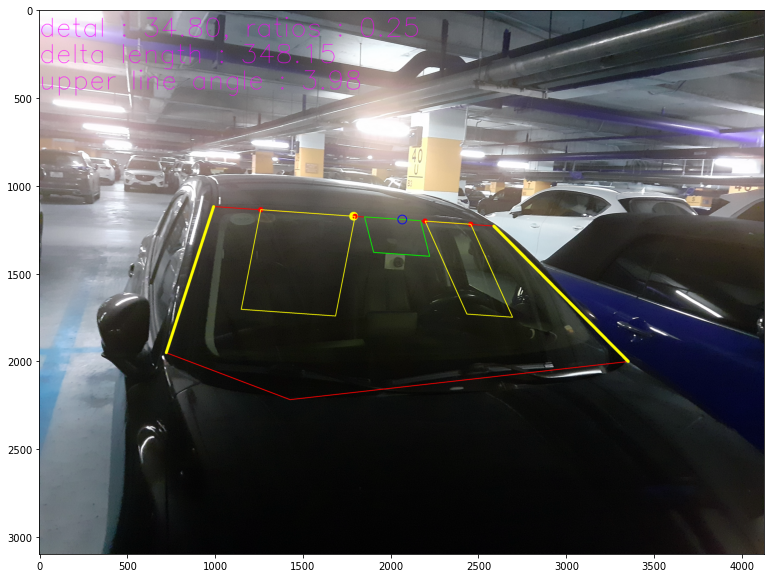

In [67]:
import math
from scipy import spatial

# find index of hightest corner of windshield
def high_of_point(point):
    return point[0][1]

# get upper line (index of highest point + its offset -> upper line)
#input : contour
#output : index + offset
def get_upper_line(cnt):
    len_cnt = len(cnt)
    highest_corner = min(cnt,key=high_of_point) 
    index = [idx for idx,p in enumerate(cnt) if (p == highest_corner).sum() == 2][0]

    p1 = cnt[(index+1)%len_cnt]
    p2 = cnt[(index-1)%len_cnt]

    norm_p1 = p1 - cnt[index]
    norm_p2 = p2 - cnt[index]

    tan_p1 = norm_p1[0][1] / norm_p1[0][0]
    tan_p2 = norm_p2[0][1] / norm_p2[0][0]

    ## upline is highest corner and its offset
    if abs(tan_p1) < abs(tan_p2):
        offset = 1
    else:
        offset = -1

    return index, offset

def get_angle(a,b,c):
    vector_ba = a-b 
    vector_bc = c-b

    cosin = 1 - spatial.distance.cosine(vector_ba,vector_bc)

    return math.acos(cosin)

def distance(p1,p2):
    vector_p = p2-p1

    return math.sqrt(np.power(vector_p,2).sum()) 

#intersect of two lines p1p2 and p3p4
#https://answers.opencv.org/question/9511/how-to-find-the-intersection-point-of-two-lines/
def cross_of_two_lines(p1,p2,p3,p4):
    #print('line 1 ',p1,p2)
    #print('line 2 ',p3,p4)
    x = p3-p1
    d1 = p2-p1
    d2 = p4-p3

    cross = d1[0][0]*d2[0][1] - d1[0][1]*d2[0][0]

    projection = (x[0][0]*d2[0][1]-x[0][1]*d2[0][0]) / cross

    intersect = (p1 + projection*d1).astype(np.int32)
    #print('cross : ',intersect)
    return intersect

# verify exception of upper line 
## angle > 150 :
#### side_len / upper_width > 0.3  -> remove point problem else add point problem
## agle > 140 and side_len / upper_width < alpha -> add point problem + alpha = ???
def verify_upper_line(cnt,index,offset):
    len_cnt = len(cnt)
    upper_width = distance(cnt[index],cnt[(index+offset)%len_cnt])
    new_cnt = cnt.copy()

    for zone_id in range(0,2):
        angle = get_angle(cnt[(index-offset+zone_id*offset)%len_cnt],cnt[(index+zone_id*offset)%len_cnt],
                          cnt[(index+offset+zone_id*offset)%len_cnt])
        #print('inside verify angle: ', angle/math.pi*180)

        side_point_id = (zone_id == 0)*(index-offset) + (zone_id == 1)*(index+2*offset)
        conern_id = (zone_id == 0)*(index) + (zone_id == 1)*(index+offset)

        side_height = distance(cnt[side_point_id%len_cnt],cnt[conern_id%len_cnt])

        ## ratio check 
        ratio = side_height/upper_width
        #print('ratio : ',side_height/upper_width)

        if angle/math.pi*180 > 150 :
            ## remove conern
            if ratio > 0.4:
                print('delete problem')
                new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)
            else:    
                ## add point
                print('add problem')
                low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
                new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                               cnt[(index+offset)%len_cnt])

                new_cnt[side_point_id%len_cnt] = new_point
                new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)

            return new_cnt,*get_upper_line(new_cnt)

        if angle/math.pi*180 > 144 and ratio < 0.4:
            print('add problem')
            low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
            new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                           cnt[(index+offset)%len_cnt])

            new_cnt[side_point_id%len_cnt] = new_point
            new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)

            return new_cnt,*get_upper_line(new_cnt)
        #side_point = cnt[side_point_id%len_cnt]

        #print('side point : ',side_point)

    return cnt,index,offset

## angle of vector1 and vector2 -> find vector2
def find_vector_from_angle(vector1,angle,vector_check):
    theta = np.power(vector1,2).sum() * math.cos(angle)**2
    a = vector1[0][0]**2 - theta
    b = 2*vector1[0][0]*vector1[0][1]
    c = vector1[0][1]**2 - theta

    result = np.roots([a,b,c])

    new_vec1 = np.array([[result[0],1]])
    check1 = abs(1 - spatial.distance.cosine(vector_check,new_vec1))
    new_vec2 = np.array([[result[1],1]])
    check2 = abs(1 - spatial.distance.cosine(vector_check,new_vec2))

    #print(check1,check2)

    if check1 > check2 :
        return new_vec1
    else:
        return new_vec2
    
### find magnitude of adjust_vector to rotate main_vector angle
def find_adjust_magnitude(adjust_vector,main_vector,adjsut_angle):
    # scalar of adjust_vector and main_vector
    x = (adjust_vector*main_vector).sum()

    # power 2 of length adjust_vector
    y = np.power(adjust_vector,2).sum()

    # power 2 of length main_vector
    z = np.power(main_vector,2).sum()

    ## quadratic
    a = x**2- math.cos(adjsut_angle)*y*z
    b = 2*x*z-2*math.cos(adjsut_angle)*x*z
    c = z**2 - math.cos(adjsut_angle)*z**2

    result = np.roots([a,b,c])

    #print(result)

    if sum(result > 0) == 1:
        return result[result>0][0]
    else:
        return min(result)

## input image, contour, start point, projection vector
## ouput height of windshield at start point
def find_windshield_height_at_point(img,cnt,point,projection):
    mask = np.zeros_like(img[:,:,0])
    i_vector = projection / math.sqrt(np.power(projection,2).sum())

    contour_mask = cv2.drawContours(mask.copy(),[cnt],-1,1,4)
    line_mask = cv2.line(mask.copy(),(point+10*i_vector).astype(np.int32)[0],
                         (point+max(img.shape[:2])*i_vector).astype(np.int32)[0],1,1)

    intersect = np.logical_and(contour_mask,line_mask)
    max_index = np.argmax(intersect)
    intersect_point = np.array([[int(max_index%mask.shape[1]),int(max_index/mask.shape[1])]])

    ws_height = distance(point,intersect_point)
    return ws_height
    
def driver_zone(image,ws_cnt):
    # simplify the contour
    peri = cv2.arcLength(ws_cnt, True)
    approx = cv2.approxPolyDP(ws_cnt, 0.02 * peri, True)
    LEN_APP = len(approx)
    
    # find upper line and verify
    index, offset = get_upper_line(approx)
    approx,index,offset = verify_upper_line(approx,index,offset)
    LEN_APP = len(approx)
    
    # draw verified contour 
    draw_image = cv2.drawContours(image.copy(),[approx],-1,(255,0,0),3)

    ## find center upper line according to pixel wise
    center = ((approx[index] + approx[(index+offset)%LEN_APP]) / 2).astype(np.int32)
    print('center : ',center)
    draw_image = cv2.circle(draw_image,center[0],radius=25, color=(255, 255, 0), thickness=-1)
    
    ## vector of upper line
    vector = approx[(index+offset)%LEN_APP]-approx[index]
    length_vector = math.sqrt(np.power(vector,2).sum()) # uper line width
    
    # vector of 2 side lines in windshield
    side_vectors = [approx[index] - approx[(index-offset)%LEN_APP],approx[(index+offset)%LEN_APP] - approx[(index+2*offset)%LEN_APP]]
    
    draw_image = cv2.line(draw_image,approx[index][0],approx[(index-offset)%LEN_APP][0],(255,255,0),15)
    draw_image = cv2.line(draw_image,approx[(index+offset)%LEN_APP][0],approx[(index+2*offset)%LEN_APP][0],(255,255,0),15)
    
    # angles of 2 upper conern in windshield
    angles = []
    for zone_id in range(0,2):
        angle = get_angle(approx[(index-offset+zone_id*offset)%LEN_APP],approx[(index+zone_id*offset)%LEN_APP],
                          approx[(index+offset+zone_id*offset)%LEN_APP])
            
        angles.append(angle)
        #draw_image = cv2.putText(draw_image,str(angle/math.pi*180),(0,150*(zone_id+1)),cv2.FONT_HERSHEY_SIMPLEX,5,
        #                         (255,0,255),2, cv2.LINE_AA)
        print('angle : ', angle/math.pi*180)
    
    # recenter base on user's camera angle
    angles = np.array(angles)
    delta = abs(angles[0] - angles[1])
    camera_angle = math.pi/2 - delta
    delta_length = length_vector*(1/math.sin(camera_angle) - 1)
    adjust_center_vector = vector*((1-angles[0]/angles[1] > 0)*1 - (1-angles[0]/angles[1] <= 0))
    adjust_ratio = 0.8 
    
    if delta/math.pi*180 > 40:
        adjust_ratio = 0.5
    elif delta/math.pi*180 < 20:
        adjust_ratio = 1
        
    new_center = (center + adjust_ratio*adjust_center_vector/length_vector*delta_length).astype(np.int32)
    print('new center : ',new_center,adjust_center_vector/length_vector*delta_length)
    
    ## center folowing bigger angles
    arg_max_angle = np.argmax(angles)
    center_angle = angles[arg_max_angle]
    #center_vector = side_vectors[arg_max_angle]
    center_vector = find_vector_from_angle(vector,center_angle,side_vectors[arg_max_angle])
    ws_height = find_windshield_height_at_point(image,approx,new_center,center_vector)
    under_center = new_center + 0.25*ws_height*center_vector/math.sqrt(np.power(center_vector,2).sum())
    under_center = under_center.astype(np.int32)
    print('under center : ',under_center)
    
    adjust_vector = approx[(index + (1-arg_max_angle)*offset)%LEN_APP] - new_center
    adjust_angle = center_angle - math.pi/2 - 0.2*delta
    print('adjust angle center : ',adjust_angle/math.pi*180)
    magnetude = find_adjust_magnitude(adjust_vector,under_center-new_center,adjust_angle)
    new_v = under_center-new_center + magnetude*adjust_vector
    new_under = new_center+new_v
    new_under = new_under.astype(np.int32)
    
    l1 = distance(approx[index],new_center)
    c1 = (approx[index]+(1-0.2)*l1*vector/length_vector).astype(np.int32)
    c2 = (c1 + 0.2*vector).astype(np.int32)
    c3 = (c1 + new_v).astype(np.int32)
    c4 = (c2 + new_v).astype(np.int32)
    
    camera_area = np.array([c1,c2,c4,c3])
    
    draw_image= cv2.drawContours(draw_image,[camera_area],-1,(0,255,0),3)
    #draw_image = cv2.circle(draw_image,z1[0],radius=25, color=(0, 255, 0), thickness=-1)
    #draw_image = cv2.circle(draw_image,z2[0],radius=25, color=(0, 255, 0), thickness=-1)
    
    
    
    
    draw_image = cv2.circle(draw_image,new_center[0],radius=25, color=(0, 0, 255), thickness=4)
    draw_image = cv2.putText(draw_image,f'detal : {delta/math.pi*180:.2f}, ratios : {1-angles[0]/angles[1]:.2f}',(0,150),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    draw_image = cv2.putText(draw_image,f'delta length : {delta_length:.2f}',(0,150*2),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    draw_image = cv2.putText(draw_image,f'upper line angle : {math.atan(vector[0][1]/vector[0][0])/math.pi*180:.2f}',(0,150*3),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    
    #return draw_image, 0 
    pre_image = draw_image.copy()
    
    
    x_ratio = distance(approx[index],new_center) / distance(new_center,approx[(index+offset)%LEN_APP])
    d_start_ratio = 0.25
    width_ratio = 0.5 

    
    # locate driver / passenger area
    for zone_id in range(0,2):         
        average_angle = angles[zone_id]
     
        check_vector = side_vectors[zone_id]
        # cos check_vector ,[[1,0]] = 0 -> use check_vector of other side
        cosin_check =  (check_vector*[[1,0]]).sum() / math.sqrt(np.power(check_vector,2).sum())
        #print('cosin check : ',cosin_check)
        if abs(cosin_check) < 0.09:
            v1 = find_vector_from_angle(vector,0.9*angles[1-zone_id],side_vectors[1-zone_id])
        else:
            v1 = find_vector_from_angle(vector,average_angle,check_vector)

        ## find height of windshield
        # find driver zone
        #width_zone = 0.2
        start_ratio = 0.18
        prefix_ratio = (zone_id==0)*d_start_ratio*x_ratio/(x_ratio+1)+(zone_id==1)*(1-(d_start_ratio+width_ratio)/(x_ratio+1))
        
        print('prefix : ',prefix_ratio,d_start_ratio,width_ratio,x_ratio)
        #projection = prefix_ratio * length_vector / 
        z_point1 = (approx[index] + prefix_ratio*vector).astype(np.int32)
        w = (zone_id==0)*width_ratio*x_ratio/(x_ratio+1)+(zone_id==1)*width_ratio/(x_ratio+1)
        z_point2 = (approx[index] + (prefix_ratio+w)*vector).astype(np.int32)
        
        draw_image = cv2.circle(draw_image,z_point1[0],radius=15, color=(255, 0, 0), thickness=-1)
        draw_image = cv2.circle(draw_image,z_point2[0],radius=15, color=(255, 0, 0), thickness=-1)
        
        ws_height = find_windshield_height_at_point(image,approx,z_point1,v1)

        projection = (0.6*ws_height/(math.sqrt(np.power(v1,2).sum())))
        projection_vector = projection*v1
        
        ## draw pre adjustion image 
        #pre_point3 = np.array(z_point2+projection_vector).astype(np.int32)
        #pre_point4 = np.array(z_point1+projection_vector).astype(np.int32)
        
        #pre_zone = np.array([z_point1,z_point2,pre_point3,pre_point4])
        #pre_image = cv2.drawContours(pre_image,[pre_zone],-1,(255,255,0),3)
        
        ##? tune this vector : projection*v1 to center
        ## vector from z_point1 -> center
        adjust_vector = center - z_point1
        
        #if average_angle > math.pi/2:
        adjsut_angle = min(abs(average_angle-math.pi/2),abs(average_angle-math.pi))
        adjust_angle = 0.7*adjsut_angle
        
        #print('adjust angle : ',adjust_angle/math.pi*180)
        if abs(cosin_check) < 0.09:
            adjsut_magnitude = 0
        else:
            adjsut_magnitude = find_adjust_magnitude(adjust_vector,projection_vector,adjust_angle)
        projection_vector = projection_vector + adjsut_magnitude*adjust_vector
        leng_projection = math.sqrt(np.power(projection_vector,2).sum())
        
        ws_height = find_windshield_height_at_point(image,approx,z_point1,projection_vector)
        projection_vector = (0.6*ws_height/leng_projection) * projection_vector
        
        z_point3 = np.array(z_point2+projection_vector).astype(np.int32)
        z_point4 = np.array(z_point1+projection_vector).astype(np.int32)
        #print('check : ',distance(z_point1,z_point2),distance(z_point3,z_point4))
        zone = np.array([z_point1,z_point2,z_point3,z_point4])

        draw_image= cv2.drawContours(draw_image,[zone],-1,(255,255,0),3)

    return draw_image, pre_image

def driver_zone_detection(image):
    ## windshield detection
    carpart_result = single_model_inference(carpart_model,image,0.5)
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    if len(windshield_semgs) == 0 :
        return image 
    
    ws_segm = max(windshield_semgs,key=lambda x : x.sum())
    contours, _ = cv2.findContours(np.array(ws_segm).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ws_contour = max(contours,key=cv2.contourArea)
    raw_cnt_image = cv2.drawContours(image.copy(),[ws_contour],-1,(255,0,0),3)
    
    ## detect driver zone
    output, pre_image = driver_zone(image,ws_contour)
    
    #result1 = np.hstack([image,raw_cnt_image])
    #result2 = np.hstack([pre_image,output])
    
    #return np.vstack([result1,result2])
    return output

#f = '/mmdetection/data/tmp/windshield/test_pipeline/38.jpg'
#f = '/mmdetection/data/tmp/windshield/real_data/20211102_201857.jpg'
#20211102_202310.jpg
f = '/mmdetection/data/tmp/windshield/real_data/20211102_202310.jpg'
#20211102_202250.jpg
#f = '/mmdetection/data/tmp/windshield/real_data/20211102_202250.jpg'
image = cv2.imread(f)
out_image = driver_zone_detection(image)

plt.figure(figsize=(15,10))
plt.imshow(out_image)

In [ ]:
f = '/mmdetection/data/tmp/windshield/test_pipeline/67929713_1239811336196307_106183138884619112_n.jpg'
image = cv2.imread(f)
out_image = driver_zone_detection(image)
plt.figure(figsize=(15,10))
plt.imshow(out_image)

In [ ]:
test_path = Path('/mmdetection/data/tmp/windshield/real_data')
files = [str(i) for i in test_path.iterdir() if i.is_file()]

out_folder = 'windshield_real_data_result'
Path(out_folder).mkdir(parents=True,exist_ok=True)

for f in tqdm(files):
    image = cv2.imread(f)
    print(f)
    out_image = driver_zone_detection(image)
    out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)
    cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],out_image)


In [ ]:
## angle > 150 :
    ## side_len / upper_width > 0.3  -> remove point problem else add point problem
## agle > 140 and side_len / upper_width < alpha -> add point problem + alpha = ???


## potential exception 20211102_203408.jpg when side_len / upper_width > 1 -> remove point problem ??? 
#146 144 
#20211102_202606.jpg notable

In [ ]:
## re center problem
#delta angle too big ??? delta > 40 (45.83 20211102_202913.jpg) -> reduce adjustment ratio from 0.9 to 0.5 ???
#delta < 18(20) -> increase adjustment ratio from 0.9 -> 1
# consider angle between upper line and horizontal in formula ??


In [ ]:
## angle of adjustment vector problem
# abs(angle1 - angle2) < 10 : adjust angle = average_angle - 90
# else adjust angle in smaller side = abs(angle - 90), adjust angle in bigger side = 0.5*abs(angle-90) ??

In [ ]:
## camera zone problem
# ratio of camera width following upper line's width ??
# ratio height = 2* camera's width
# angle = 

In [ ]:
## driver/passenger zone problem
# width and start point
# angle if delta > 20 , small side follow bigger one